In [1]:
# Run this cell to import all the necessary components
from include.init_rocket.CustomRocket import CustomRocket
from include.init_rocket.RocketPlotter import RocketPlotter

In [2]:
# Run this cell to create all necessary widgets
%run -i include/widgets/widgets.py

# Rocket construction
## Geometry and Mass 
The first step is to chose the geometry and mass properties of your rocket. Each component (nose, tube, fins) can have its own density and shape. Fill the following form to specify your rocket's properties.

In [3]:
# Run this cell
rocket_properties_widget

## Motor picker

This section will allow you to chose the right motor for your rocket based on the desired impulse class and diameter.

$(\textit{Motors data is loaded from the JSON file :  } \texttt{include/widgets/motor\_data.json})$

You will have to chose the two following properties in order to access the motor choice.
### Impulse class : 
The <b>impulse class</b> is a letter code assigned to a range of total impulse with each letter being twice as powerful as the previous.
- A : 1.26–2.50 (N.s),
- B : 2.51–5.00,
- C : 5.01–10.0,
- D : 10.01–20.0,
- E : 20.01–40.0,
- F : 40.01–80.0,
- G : 80.01–160,
- H : 160.01–320,
- I : 320.01–640,
- J : 640.01–1,280,
- K : 1,280.01–2,560,
- L : 2,560.01–5,120,
- M : 5,120.01–10,240,
- N : 10,240.01–20,480,
- O : 20,480.01–40,960
### Motor geometry :
The main diameter of the motor is expressed in millimeters.

The position of the motor corresponds to the distance between the bottom of the motor and the bottom of the tube in meters.

In [5]:
# Run this cell
motor_selection_widget

Accordion(children=(Dropdown(description='Impulse Class (N.s):', options=(('[1.26 - 2.50]', 'A'), ('[2.51 - 5.…

## Parachutes settings

In this section, you will have to specify the various properties of the parachute.

In [6]:
# Run this cell
parachute_widget

## Additional masses
In this section you can create additional mass component to add to your rocket.

These components are represented as cylinders or empty cylinders, but can play the role of various inner components for your rocket such as a partition or an electrical component.

In [7]:
# Run this cell
additional_masses_widget

Accordion(children=(VBox(children=(BoundedIntText(value=0, description='Number of additional masses', style=De…

## Launching parameters
Last parameters to ajust for launching.

Specify launching parameters for the simulation.

In [4]:
# Run this cell
launching_parameters_widget

## Creation of the rocket
All properties you have previously entered will be stored in the $\texttt{'rocket'}$ object as you run this cell.

It's properties are stored in the $\texttt{'rocket\_dict.json'}$ file.

You can also create your rocket by directly specifying its properties in the file. All properties must be specified in the dictionary.

(Please refer to the documentation for more details about the format of each entry.)

In [16]:
# Run this cell to update the rocket and create its corresponding CustomRocket object
# Look at the documentation from widgets.py for the use of data_source parameter
myrocket = rocket_creation(data_source="widgets")

## Plot the rocket

In [17]:
# Print mass properties of your rocket
myrocket.print_properties()

# Plot your rocket using PyVista and pythreejs
rocketPlotter = RocketPlotter(myrocket)
# You can chose to plot only the outside of the rocket and/or to plot an opened version of the rocket to visualize its interior
rocketPlotter.plot(only_ext=False, opened=True)

Volume (m^3)                                 = 0.002547154913846346
Mass   (kg)                                  = 6.6652864535708085


Position of the center of gravity (COG)      = [0.34229485 0.         0.        ]
Position of the center of pressure (CPA)     = [0.18040174 0.         0.        ]


Inertia matrix expressed at the COG (kg*m^2) = [0.00313583 0.         0.        ]
                                               [0.        0.2871233 0.       ]
                                               [0.        0.        0.2871233]


AttributeError: type object 'DataImage' has no attribute '_instance_inits'

## Simulation
In this section you will simulate your rocket's flight.

A new window containing the plot of your rocket's trajectory will appear.

In [18]:
import sys
sys.path.append('./model')
from Earth import Earth

Earth('earth')

earth - Earth

In [19]:
# Run this cell to start the simulation
%run model/rocket_trajectory.py

___PARACHUTE DEPLOYMENT___


Rocket X Coordinate at Deployment:  76.67648240497664 m
Rocket Y Coordinate at Deployment:  0.0 m
Rocket Z Coordinate at Deployment:  209.32525946107233 m


___PARACHUTE DEPLOYMENT___


Parachute fully deployed !


In [14]:
# Run this cell for important simulation values

simulation_values()



Apogee Height:  209.32621382453658 m


Total Flight Time:  26.682706410163487 s


Landing Point:  92.95230908621197 m


Lowest Pressure 95195.87943521072




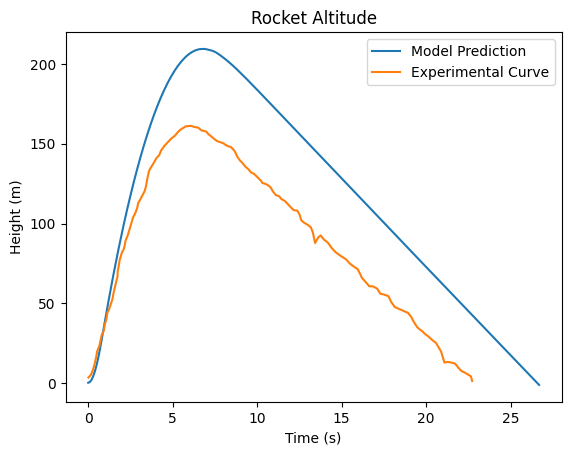

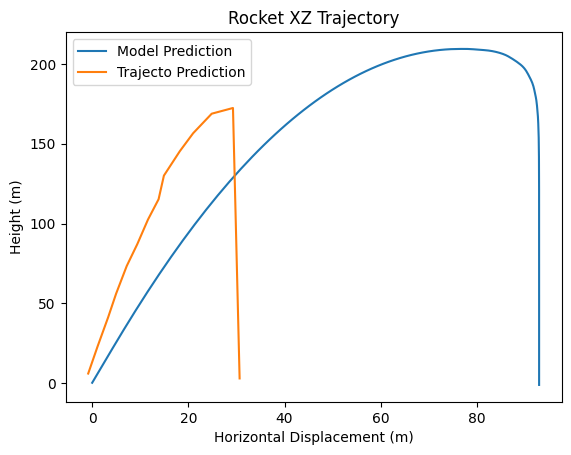

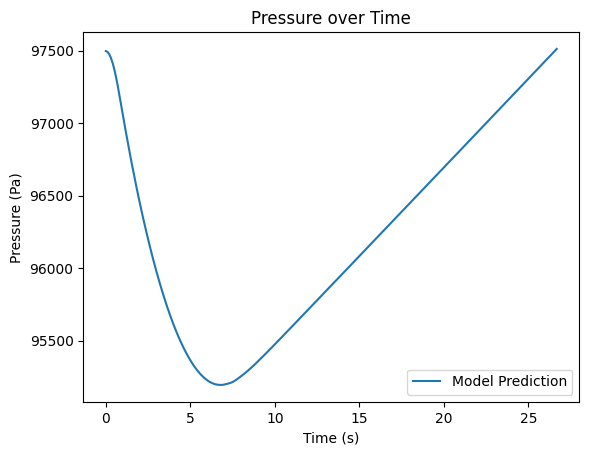

In [15]:
# Run this cell for additional plots concerning the simulation
simulation_2d_plots()